## FAO
The FAO Food Price Index (FFPI) is a measure of the monthly change in international prices of a basket of food commodities. It consists of the average of five commodity group price indices weighted by the average export shares of each of the groups over 2014-2016. A feature article published in the June 2020 edition of the Food Outlook presents the revision of the base period for the calculation of the FFPI and the expansion of its price coverage, to be introduced from July 2020. A November 2013 article contains technical background on the previous construction of the FFPI.

### Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
!pip install arch
import arch.unitroot as at
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model
import scipy.stats as stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
!pip install optuna
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/food_price.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_excel(file_path)

In [ ]:
df.head()

,index,food_price_index,meat,dairy,cereals,oil,sugar
0,1,64.444201,74.272219,53.503031,64.140607,44.587672,87.877833
1,2,64.728299,76.781027,52.218634,62.222377,44.500514,90.662693
2,3,64.033021,78.543983,41.367123,61.259884,45.745434,95.056585
3,4,66.015997,81.190035,48.427068,62.820731,44.017094,94.313956
4,5,64.632844,81.756679,39.189651,61.982826,45.499631,90.353265


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             426 non-null    int64  
 1   food_price_index  426 non-null    float64
 2   meat              426 non-null    float64
 3   dairy             426 non-null    float64
 4   cereals           426 non-null    float64
 5   oil               426 non-null    float64
 6   sugar             426 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 23.4 KB


### Graphs of commodities price vs month

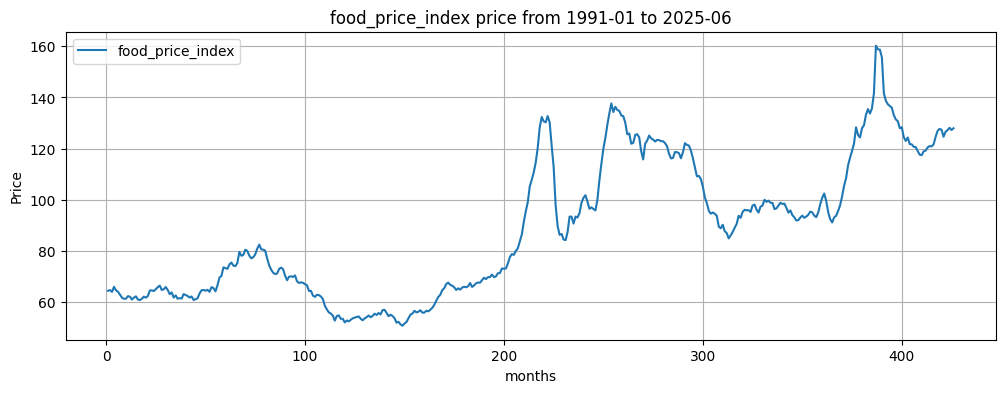

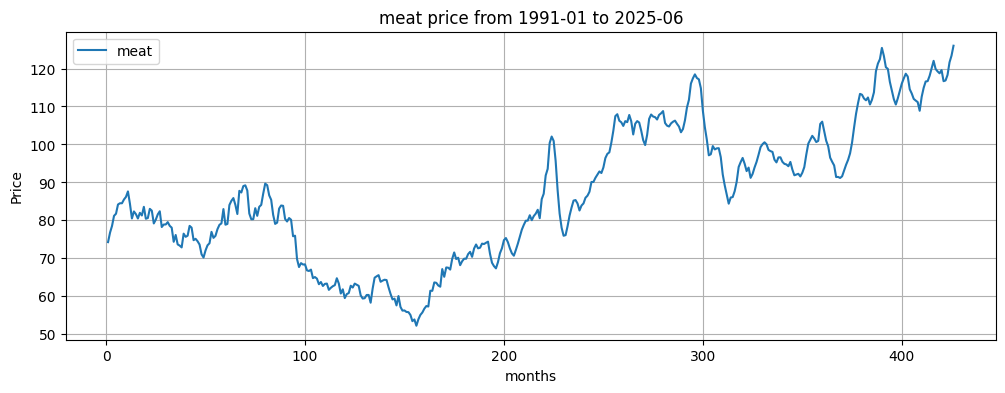

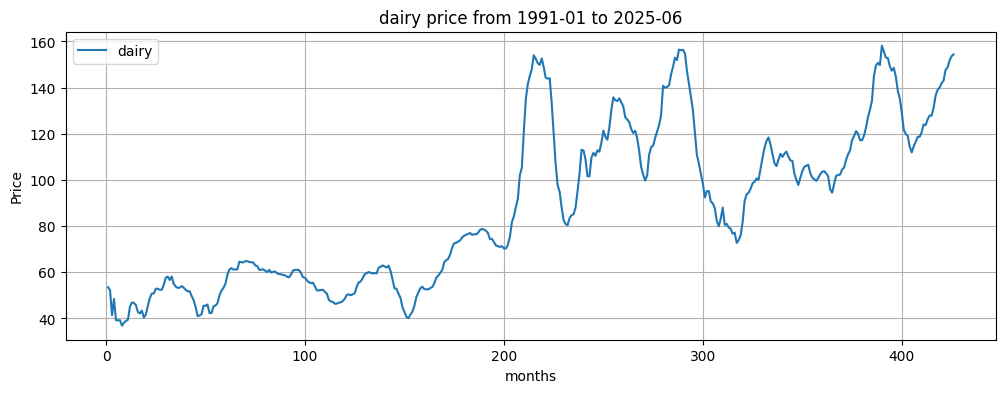

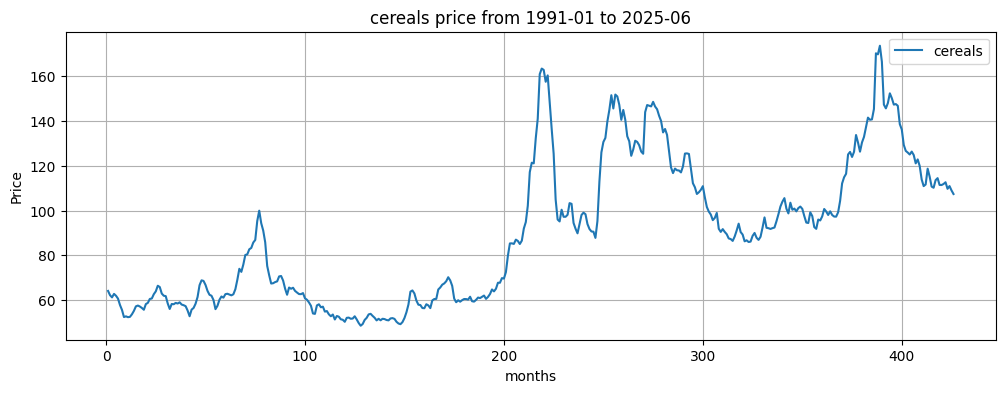

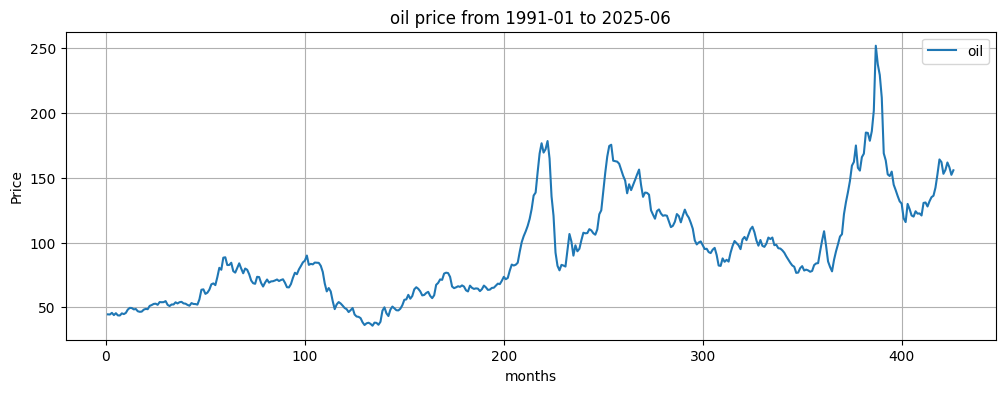

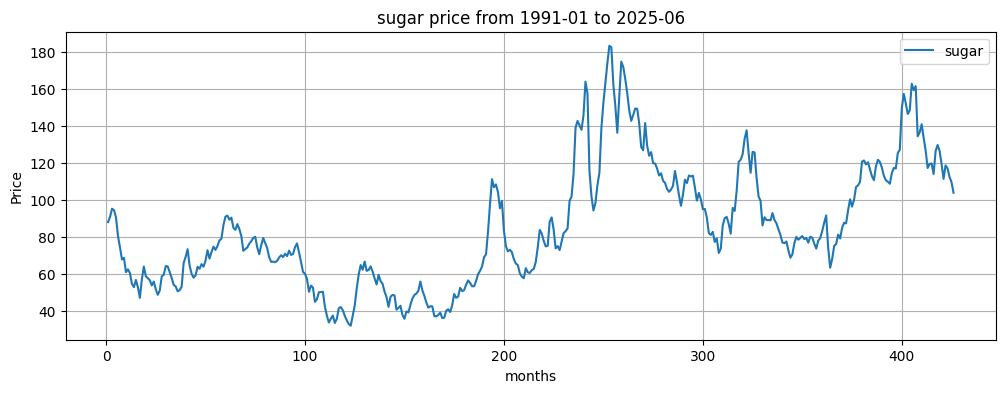

In [ ]:

for j,i in enumerate(df.columns):
  if(i!='index'):
   plt.figure(figsize=(12, 4))
   plt.plot(df['index'],df[i],label=i)
   plt.title(f'{i} price from 1991-01 to 2025-06')
   plt.xlabel('months')
   plt.ylabel('Price')
   plt.legend()
   plt.grid(True)
   plt.show()

## Descriptive Statistics

In [ ]:
df.drop(columns=['index']).describe()

,food_price_index,meat,dairy,cereals,oil,sugar
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,88.578161,86.904157,87.911118,89.403809,92.680559,84.749989
std,27.028696,18.062194,34.588617,31.770842,39.274414,32.919904
min,50.804002,52.255639,36.826686,48.616170,35.827683,31.809300
25%,64.623615,73.001974,57.034267,60.576514,63.724875,59.920924
50%,86.386823,84.488564,80.686521,87.675018,82.824054,77.842916
75%,115.503234,100.931274,115.861471,112.028623,118.607054,108.880694
max,160.224455,126.001044,158.158613,173.520749,251.831272,183.237658


In [ ]:
# Skewness and Kurtosis
for j,i in enumerate(df.columns):
  if(i!='index'):
   skewness=df[i].skew()
   print(f'Skewness of {i} is {skewness}')
   kurtosis=df[i].kurtosis()
   print(f'Kurtosis of {i} is {kurtosis}')

Skewness of food_price_index is 0.4201957383180882
Kurtosis of food_price_index is -1.0383954186395847
Skewness of meat is 0.1545692400868471
Kurtosis of meat is -0.9376499701908667
Skewness of dairy is 0.36283000652307723
Kurtosis of dairy is -1.1492298281202111
Skewness of cereals is 0.5613002487286599
Kurtosis of cereals is -0.7917972640157389
Skewness of oil is 0.9221708012002123
Kurtosis of oil is 0.5916762541055887
Skewness of sugar is 0.6711122858899722
Kurtosis of sugar is -0.15388314208259102


positive skewness is shown by all the commodities, indicating an upward trend

## Plotting density plot for each commodities

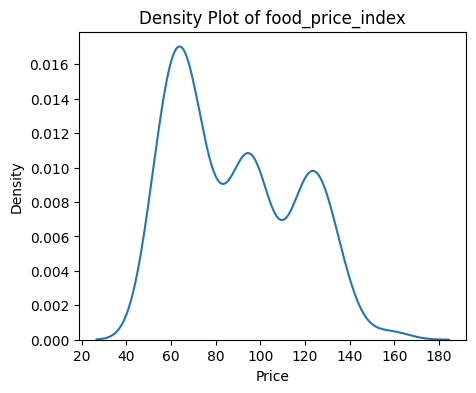

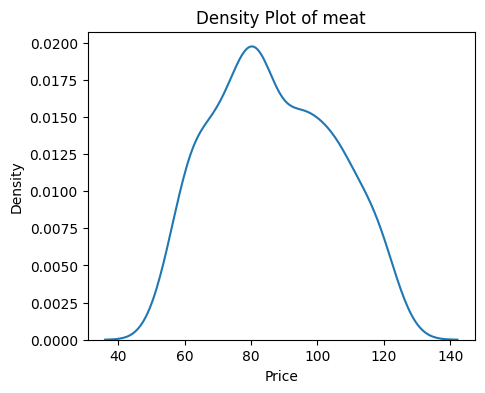

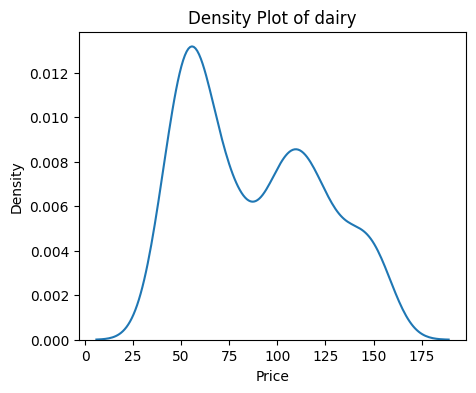

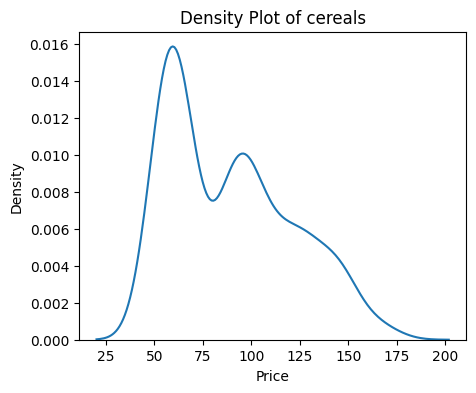

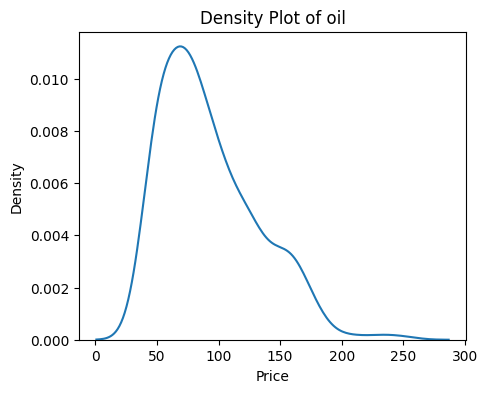

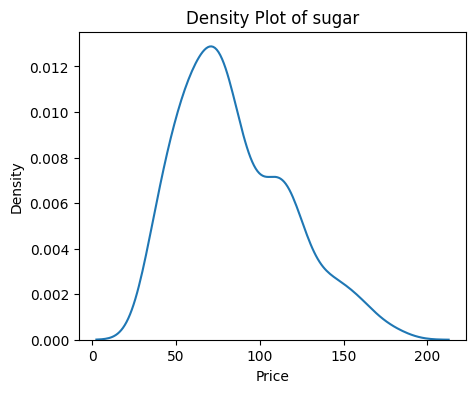

In [ ]:
for j,i in enumerate(df.columns):
  if(i!='index'):
   plt.figure(figsize=(5, 4))
   plt.title(f'Density Plot of {i}')
   plt.xlabel('Price')
   plt.ylabel('Density')
   sns.kdeplot(df[i])
   plt.show()

# Train Test Split

In [ ]:
split_index = int(len(df) * 0.93)


train = df.iloc[:split_index]
test = df.iloc[split_index:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 396
Test size: 30


# APPLYING ARIMA MODEL ON DIFFERENT COMMODITIES

### Let's first check the stationarity for different series

In [ ]:
# Applying Augmented Dickey Fuller Test to test Stationarity
alp=0.05   #(significance level)
from statsmodels.tsa.stattools import adfuller

for j,i in enumerate(train.columns):
  if(i!='index'):
    adf_test=adfuller(train[i])
    print(f'results for {i}')
    print('ADF Statistics',adf_test[0])
    print('p-value',adf_test[1])
    if(adf_test[1]>alp):
      print(f'{i} Series is not stationary')
    else:
      print(f'{i} Series is stationary')
    print('-----------------------------\n')

results for food_price_index
ADF Statistics -1.3380948310780345
p-value 0.6115687745320484
food_price_index Series is not stationary
-----------------------------

results for meat
ADF Statistics -0.7335460460745095
p-value 0.8378679881460872
meat Series is not stationary
-----------------------------

results for dairy
ADF Statistics -1.2502367896288606
p-value 0.6516207049539166
dairy Series is not stationary
-----------------------------

results for cereals
ADF Statistics -1.6716167654165592
p-value 0.4457924905079542
cereals Series is not stationary
-----------------------------

results for oil
ADF Statistics -1.941662494973826
p-value 0.31272257065253417
oil Series is not stationary
-----------------------------

results for sugar
ADF Statistics -2.312390941430371
p-value 0.16800278359137044
sugar Series is not stationary
-----------------------------



In [ ]:
!pip install arch
import arch.unitroot as at

In [ ]:
# Applying Phillips-Perron Test
alp=0.05   #(significance level)
for j,i in enumerate(train.columns):
  if(i!='index'):
    pp_test=at.PhillipsPerron(train[i], trend='ct',test_type='tau')
    pp_stat=pp_test.stat
    p_value=pp_test.pvalue
    print(f'results for {i}')
    print('PP Statistics',pp_stat)
    print('p-value',p_value)
    if(p_value>alp):
      print(f'{i} Series is not stationary')
    else:
      print(f'{i} Series is stationary')
    print('-----------------------------\n')


results for food_price_index
PP Statistics -2.3607335163705385
p-value 0.4006914527470594
food_price_index Series is not stationary
-----------------------------

results for meat
PP Statistics -2.0504234303448383
p-value 0.5737214431111066
meat Series is not stationary
-----------------------------

results for dairy
PP Statistics -3.0928681228675536
p-value 0.1079368558513204
dairy Series is not stationary
-----------------------------

results for cereals
PP Statistics -2.5379472169763098
p-value 0.30925686651490736
cereals Series is not stationary
-----------------------------

results for oil
PP Statistics -3.0019153163012158
p-value 0.13154629444657673
oil Series is not stationary
-----------------------------

results for sugar
PP Statistics -2.7712144100833975
p-value 0.2077178479231625
sugar Series is not stationary
-----------------------------



Hence from adf and pp test we conclude that all the series are not stationary

# Let's apply differencing and check for stationarity

In [ ]:
# Applying Augmented Dickey Fuller Test to test Stationarity after first order differencing

for j,i in enumerate(train.columns):
  if(i!='index'):
    t=train[i].diff().dropna()
    adf_test=adfuller(t)
    print(f'results for {i}')
    print('ADF Statistics',adf_test[0])
    print('p-value',adf_test[1])
    if(adf_test[1]>alp):
      print(f'{i} first order difference series is not stationary')
    else:
      print(f'{i} first order difference Series is stationary')
    print('-----------------------------\n')


results for food_price_index
ADF Statistics -11.548955001525428
p-value 3.485201787027739e-21
food_price_index first order difference Series is stationary
-----------------------------

results for meat
ADF Statistics -5.870760453625896
p-value 3.244456699653459e-07
meat first order difference Series is stationary
-----------------------------

results for dairy
ADF Statistics -6.842629043177612
p-value 1.7752283042131733e-09
dairy first order difference Series is stationary
-----------------------------

results for cereals
ADF Statistics -12.802876485276283
p-value 6.695785994996782e-24
cereals first order difference Series is stationary
-----------------------------

results for oil
ADF Statistics -5.745235445342415
p-value 6.14325104024001e-07
oil first order difference Series is stationary
-----------------------------

results for sugar
ADF Statistics -13.372139431986641
p-value 5.172641413534905e-25
sugar first order difference Series is stationary
-----------------------------


In [ ]:
# Applying Phillips-Perron Test after first order differencing
alp=0.05   #(significance level)
for j,i in enumerate(train.columns):
  if(i!='index'):
    t=train[i].diff().dropna()
    pp_test=at.PhillipsPerron(t, trend='ct',test_type='tau')
    pp_stat=pp_test.stat
    p_value=pp_test.pvalue
    print(f'results for {i}')
    print('PP Statistics',pp_stat)
    print('p-value',p_value)
    if(p_value>alp):
      print(f'{i} Series is not stationary')
    else:
      print(f'{i} Series is stationary')
    print('-----------------------------\n')


results for food_price_index
PP Statistics -11.3841893660818
p-value 4.332772631271751e-18
food_price_index Series is stationary
-----------------------------

results for meat
PP Statistics -13.655243352976486
p-value 2.3674547816778334e-21
meat Series is stationary
-----------------------------

results for dairy
PP Statistics -11.50203740363687
p-value 2.671890664795815e-18
dairy Series is stationary
-----------------------------

results for cereals
PP Statistics -12.280785836775541
p-value 1.3908843640503548e-19
cereals Series is stationary
-----------------------------

results for oil
PP Statistics -13.180512380313466
p-value 8.096910488879886e-21
oil Series is stationary
-----------------------------

results for sugar
PP Statistics -13.440689685708307
p-value 4.0286908835395e-21
sugar Series is stationary
-----------------------------



So first order difference series are stationary for all commodities

## Plotting ACF and PACF plot to get idea about p,q in ARIMA(p,d,q) for food_price_index series

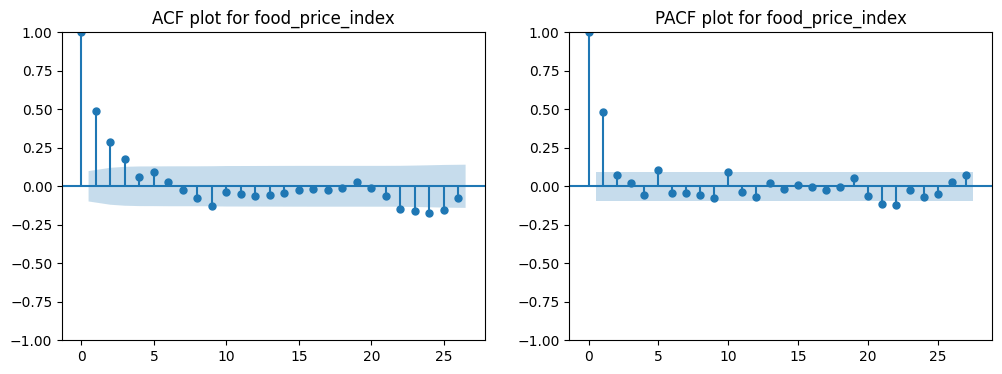

In [ ]:
# plotting ACF and PACF plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
i='food_price_index'
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train[i].diff().dropna(), ax=axes[0])
axes[0].set_title(f'ACF plot for {i}')
plot_pacf(df[i].diff().dropna(), ax=axes[1])
axes[1].set_title(f'PACF plot for {i}')
plt.show()

### Let's fit ARIMA model in Food_price_index


from graph we can interpret that

Significant spikes at lag 1, 2, 3, then slowly tapering off.

This suggests the presence of MA components.

Likely MA order q = 1,2 or 3

Significant spike at lag 1, then small spikes diminishing.

This pattern is typical of AR(1) or AR(2).

Likely AR order p = 1 or 2

we can try a few combinations like:

ARIMA(1, 1, 2)    since after first order differencing it becomes stationary

ARIMA(2, 1, 2)

ARIMA(2, 1, 3)

ARIMA(1,1,1)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(train[i], order=(1, 1, 2)).fit()
model2 = ARIMA(train[i], order=(2, 1, 2)).fit()
model3 = ARIMA(train[i], order=(2, 1, 3)).fit()
model4 = ARIMA(train[i], order=(1, 1, 1)).fit()
model5 = ARIMA(train[i], order=(3, 1, 3)).fit()



print("Model 1 AIC:", model1.aic, " | BIC:", model1.bic)
print("Model 2 AIC:", model2.aic, " | BIC:", model2.bic)
print("Model 3 AIC:", model3.aic, " | BIC:", model3.bic)
print("Model 4 AIC:", model4.aic, " | BIC:", model4.bic)
print("Model 5 AIC:", model5.aic, " | BIC:", model5.bic)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model 1 AIC: 1760.8517864875241  | BIC: 1776.7673295471286
Model 2 AIC: 1761.3086340061793  | BIC: 1781.203062830685
Model 3 AIC: 1761.2563820361156  | BIC: 1785.1296966255222
Model 4 AIC: 1758.8517988894903  | BIC: 1770.7884561841936
Model 5 AIC: 1759.682449439594  | BIC: 1787.5346497939017


Model 4 has comparatively low AIC and BIC let's move ahead with this model

### Ljung-Box test

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residualsa = model4.resid

lb_test = acorr_ljungbox(residualsa, lags=[10], return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
10  2.846823   0.984802


Ljung-Box Q Test (p > 0.05)

Residuals are not autocorrelated → Good fit.

### Q-Q plot

<Figure size 400x400 with 0 Axes>

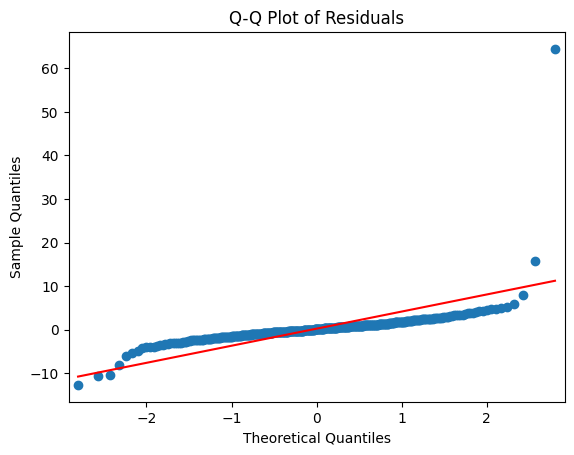

In [ ]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(4, 4))
qqplot(residualsa, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

The Q-Q plots show the evidence of the presence of
volatility in residuals, implying that the GARCH model needs to be
applied.

ARIMA model may have captured the mean structure well (Ljung-Box p-value was good) but not the variance (volatility) structure.

The presence of non-normality and volatility in residuals strongly suggests:

### Let's Perform ARCH LM Test to detect volatility at lags 10,15,20

In [ ]:
from statsmodels.stats.diagnostic import het_arch
l=10
arch_test_result = het_arch(residualsa, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')

l=15
arch_test_result = het_arch(residualsa, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')

l=20
arch_test_result = het_arch(residualsa, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')


for lag 10
LM Statistic: 87.27570267215349
p-value: 1.8546824818218854e-14
---------------------------------
for lag 15
LM Statistic: 95.70514414237552
p-value: 8.452461405079252e-14
---------------------------------
for lag 20
LM Statistic: 96.95435713406945
p-value: 4.400815491895524e-12
---------------------------------


p Value suggests that there is Volatility in the model

In [ ]:
# Get parameters and standard errors
params = model4.params
stderr = model4.bse

print(f'Estimated parameters are \n{params}')
print('------------------------')
print(f'Standard errors are \n{stderr}')

Estimated parameters are 
ar.L1     0.591847
ma.L1    -0.132966
sigma2    4.948055
dtype: float64
------------------------
Standard errors are 
ar.L1     0.071927
ma.L1     0.088792
sigma2    0.143413
dtype: float64


Forecasting

In [ ]:

forecasta = model4.forecast(steps=len(test[i]))
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test[i], forecasta)
mae = mean_absolute_error(test[i], forecasta)
rmse=mse**0.5
residualsaf=test[i]-forecasta

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae:.2f}")


Test RMSE: 6.959275767314473
Test MAE: 5.90


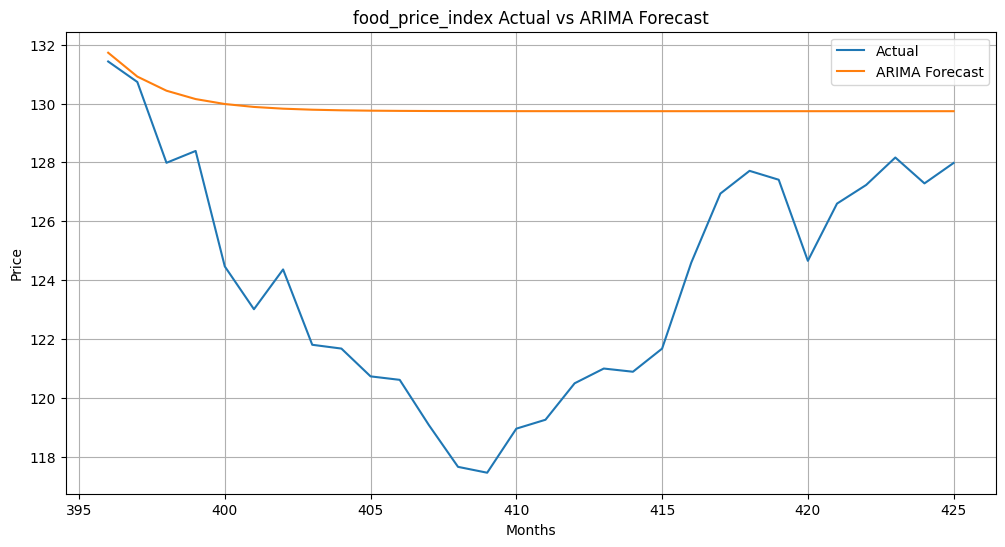

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test[i].index, test[i].values, label='Actual')
plt.plot(test[i].index, forecasta, label='ARIMA Forecast')
plt.title(f'{i} Actual vs ARIMA Forecast')
plt.xlabel('Months')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Let's fit ARIMA GARCH model in Food Price index

In [ ]:
! pip install arch


In [ ]:
from arch import arch_model

In [ ]:
# Example: Let's assume `residuals` is your residual series from ARIMA or original returns
# Replace this with your actual residuals or return series
residualsg = pd.Series(residualsa)

# Step 1: Define and fit a GARCH(1,1) model
# mean='Zero' assumes mean is handled by ARIMA (or returns have zero mean)
model = arch_model(residualsg, vol='Garch', p=1, q=1, mean='Constant')
garch_result = model.fit(disp='off')

# Step 2: Summary of the model
print(garch_result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -813.313
Distribution:                  Normal   AIC:                           1634.63
Method:            Maximum Likelihood   BIC:                           1650.55
                                        No. Observations:                  396
Date:                Tue, Aug 19 2025   Df Residuals:                      395
Time:                        19:01:20   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0458  6.580e-02      0.696      0.487 [-8.32

GARCH model is fitted correctly, including the constant mean mu.

The mu parameter is not statistically significant, implying the mean effect is weak.

beta is highly significant, showing strong GARCH (volatility persistence).

omega is marginally significant, which is typical in financial-style data.



In [ ]:
garch_forecast=garch_result.forecast(horizon=len(test[i]))
vol_forecast=np.sqrt(garch_forecast.variance.values[-1,:])

np.random.seed(42)
z=np.random.normal(size=len(test[i]))
simulated_residualsg=vol_forecast*z

final_forecastg=forecasta + simulated_residualsg

In [ ]:
simulated_residualsg

array([ 1.2649917 , -0.35820397,  1.70484125,  4.06851947, -0.63415968,
       -0.64230208,  4.38447807,  2.15473961, -1.33210173,  1.55477013,
       -1.34037608, -1.35889605,  0.71183339, -5.67262407, -5.15180339,
       -1.6910586 , -3.06607257,  0.9572138 , -2.78216852, -4.351398  ,
        4.5396211 , -0.70281195,  0.21120604, -4.47626171, -1.71767073,
        0.35141597, -3.66060831,  1.19926736, -1.92402012, -0.93749584])

In [ ]:
mse = mean_squared_error(test[i], final_forecastg)
mae = mean_absolute_error(test[i], final_forecastg)
rmse=mse**0.5

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae:.2f}")

Test RMSE: 6.490984382044598
Test MAE: 5.51


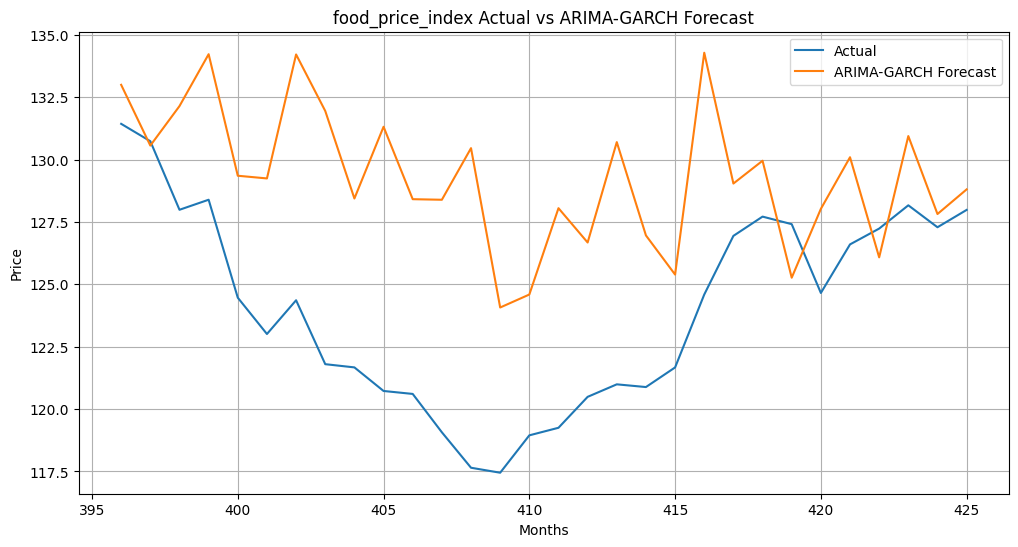

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test[i].index, test[i].values, label='Actual')
plt.plot(test[i].index, final_forecastg, label='ARIMA-GARCH Forecast')
plt.title(f'{i} Actual vs ARIMA-GARCH Forecast')
plt.xlabel('Months')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Applying Ljung-Box test

In [ ]:
std_residg = garch_result.std_resid.dropna()
#lag =5
lb_test = acorr_ljungbox(std_residg, lags=[5], return_df=True)
print(lb_test)

#lag=9
lb_test = acorr_ljungbox(std_residg, lags=[9], return_df=True)
print(lb_test)

#lag=30
lb_test = acorr_ljungbox(std_residg, lags=[30], return_df=True)
print(lb_test)


    lb_stat  lb_pvalue
5  2.613566   0.759303
    lb_stat  lb_pvalue
9  7.010959   0.635978
      lb_stat  lb_pvalue
30  33.398143   0.305527


the
normality of the residuals again confirmed by the Ljung-Box Q test as pvalue
was greater than 0.05.

Q-Q Plot


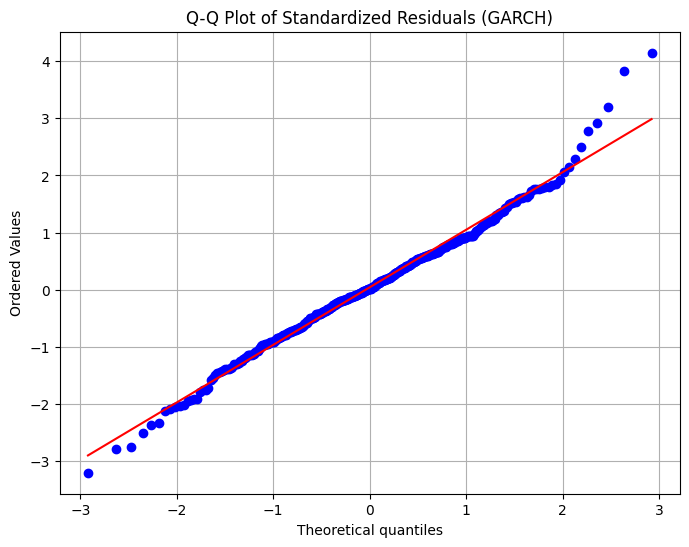

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(std_residg, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals (GARCH)")
plt.grid(True)
plt.show()


 GARCH model captures the volatility pattern well, but:

The normal distribution assumption for residuals may not hold, especially in the extremes (outliers).

This is common in financial/commodity time series where shocks are larger than normal.



### Let's Perform ARCH LM Test to detect volatility at lags 10,15,20

In [ ]:
from statsmodels.stats.diagnostic import het_arch
l=10
arch_test_result = het_arch(std_residg, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')

l=15
arch_test_result = het_arch(std_residg, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')

l=20
arch_test_result = het_arch(std_residg, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')


for lag 10
LM Statistic: 6.493070206875788
p-value: 0.7722777194921888
---------------------------------
for lag 15
LM Statistic: 27.908627911831367
p-value: 0.022148036719507817
---------------------------------
for lag 20
LM Statistic: 28.308065438720654
p-value: 0.10230504099167312
---------------------------------


For lags 10 and 20, p-values > 0.05 → no significant ARCH effects, meaning your GARCH model is capturing volatility well at those horizons.

But at lag 15, p-value = 0.0294 < 0.05 → some remaining ARCH effect.
This could suggest:

Volatility patterns are still present that the current GARCH(1,1) isn't fully modeling

Or that it’s just a mild outlier, especially if lags 10 and 20 are fine

Q-Q plot suggets that to use a different distribution in your GARCH model:

Trying Student’s t-distribution (which allows heavier tails):




# TARCH(1,1)

In [ ]:

residualst = pd.Series(residualsa)
# Fit a TARCH(1,1) model with t-distribution
model = arch_model(residualst, vol='GARCH', p=1, o=1, q=1, mean='Zero', dist='t')
tarch_result = model.fit(disp='off')

# Summary of the model
print(tarch_result.summary())


                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.003
Vol Model:                        GJR-GARCH   Log-Likelihood:               -806.840
Distribution:      Standardized Student's t   AIC:                           1623.68
Method:                  Maximum Likelihood   BIC:                           1643.59
                                              No. Observations:                  396
Date:                      Tue, Aug 19 2025   Df Residuals:                      396
Time:                              19:01:21   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

1. Volatility is present and predictable:
alpha[1] (ARCH effect) = 0.5196, p < 0.01
→ Large, recent shocks significantly increase volatility.

beta[1] (GARCH effect) = 0.4174, p < 0.01
→ Volatility is persistent over time.

Together, these confirm the presence of volatility clustering.

2. Asymmetric effects are not significant:
gamma[1] = −0.1435, p = 0.481
→ This means negative shocks don't significantly increase volatility more than positive shocks, i.e., asymmetry is not present.

3. Fat tails (non-normality) are confirmed:
nu (degrees of freedom for Student's t) = 7.28, p = 0.0052
→ Your data has leptokurtosis (fat tails), validating what your Q-Q plot earlier showed.

4. Overall model quality:
AIC = 1673.58, BIC = 1693.63
→ Use these to compare with other models (e.g., ARIMA-GARCH). Lower is better.



In [ ]:
# Forecast volatility for the desired horizon (e.g., length of test set)
horizon = len(test[i])  # or any other forecast horizon
forecast_t = tarch_result.forecast(horizon=horizon)

# Get forecasted conditional variances
cond_var = forecast_t.variance.values[-1]  # shape: (horizon,)
sigma_t = np.sqrt(cond_var)  # conditional standard deviation

nu = tarch_result.params['nu']  # degrees of freedom from fitted t-distribution

np.random.seed(42)  # for reproducibility

# Simulate standardized shocks z_t ~ t(nu)
z_t = np.random.standard_t(df=nu, size=horizon)

simulated_residualst = sigma_t * z_t

final_forecastt = forecasta + simulated_residualst


In [ ]:

simulated_residualst

array([ 1.21076628, -2.41586918,  3.09018574, -1.62638881,  1.12350461,
        3.25442853, -3.48512195, -1.31876104, -1.29859881, -1.16272575,
       -0.95744712, -1.32437571,  2.99379221,  5.12675845,  1.75527924,
       -4.22329521, -0.88036416, -2.72312149, -1.44215581,  1.16055759,
       -2.29509537, -2.86484996, -4.03042712,  1.93293085,  1.09711027,
        3.427523  , -5.32201679, -2.73663667, -0.50138527, -1.63502387])

In [ ]:

mse = mean_squared_error(test[i], final_forecastt)
mae = mean_absolute_error(test[i], final_forecastt)
rmse=mse**0.5

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae:.2f}")

Test RMSE: 7.292367176356926
Test MAE: 5.91


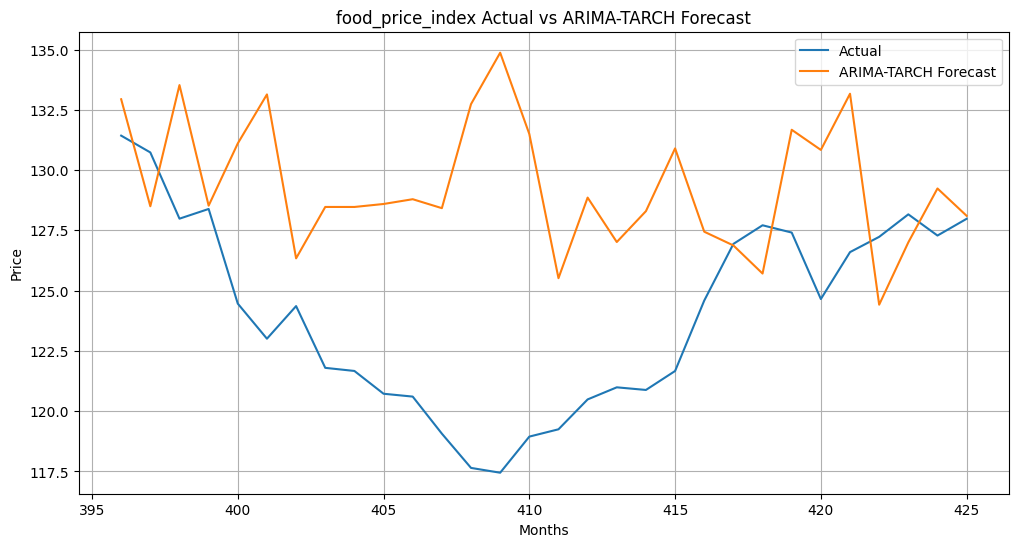

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test[i].index, test[i].values, label='Actual')
plt.plot(test[i].index, final_forecastt, label='ARIMA-TARCH Forecast')
plt.title(f'{i} Actual vs ARIMA-TARCH Forecast')
plt.xlabel('Months')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Applying Ljung-Box Plot

In [ ]:
std_residt = tarch_result.std_resid.dropna()
#lag =5
lb_test = acorr_ljungbox(std_residt, lags=[5], return_df=True)
print(lb_test)

#lag=9
lb_test = acorr_ljungbox(std_residt, lags=[9], return_df=True)
print(lb_test)

#lag=30
lb_test = acorr_ljungbox(std_residt, lags=[30], return_df=True)
print(lb_test)


    lb_stat  lb_pvalue
5  2.631222   0.756616
    lb_stat  lb_pvalue
9  6.585553   0.680181
      lb_stat  lb_pvalue
30  32.327526   0.352453


p_value > 0.05 hence normality of the residuals being confirmed

# Q-Q Plot

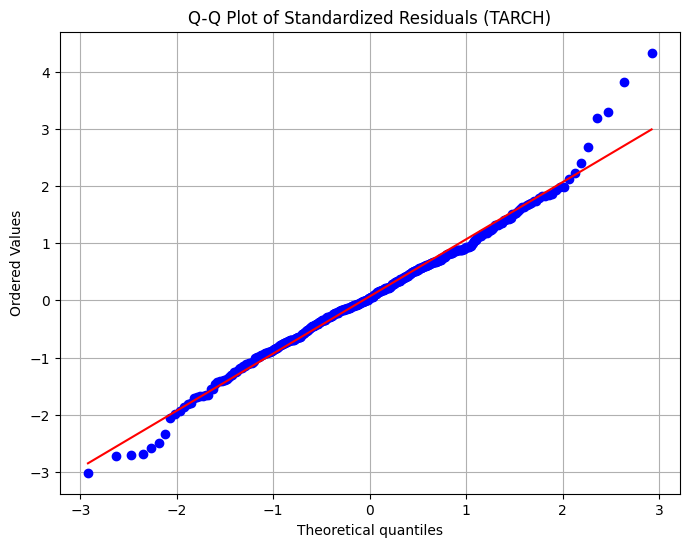

In [ ]:
plt.figure(figsize=(8, 6))
stats.probplot(std_residt, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals (TARCH)")
plt.grid(True)
plt.show()

TARCH model is working well overall — it captured the volatility and handled the fat tails quite well.

Minor remaining deviations in the tail are common in real data, and this level of fit is typically considered satisfactory

### Let's Perform ARCH LM Test to detect volatility at lags 10,15,20

In [ ]:
from statsmodels.stats.diagnostic import het_arch
l=10
arch_test_result = het_arch(std_residt, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')

l=15
arch_test_result = het_arch(std_residt, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')

l=20
arch_test_result = het_arch(std_residt, nlags=l)
print(f'for lag {l}')
print("LM Statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print('---------------------------------')


for lag 10
LM Statistic: 8.904693703683709
p-value: 0.5411718124209328
---------------------------------
for lag 15
LM Statistic: 30.422925051860172
p-value: 0.010484598408176848
---------------------------------
for lag 20
LM Statistic: 31.58232593397061
p-value: 0.0479572795599317
---------------------------------


 TARCH model is mostly successful, especially if lags 10 and 20 are clean.

The lag 15 result might be a mild warning, but could also be due to noise or sampling.



# Applying LSTM on Food price index


# OPTUNA

In [ ]:
def objective(trial):
  try:
    batch_size=trial.suggest_int('batch_size', 2, 8)
    LSTM_units=trial.suggest_int('LSTM_units', 40, 70)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    epochs=trial.suggest_int('epochs', 25, 50)

    scaler = MinMaxScaler()
    train_scaled= scaler.fit_transform(train[i].values.reshape(-1, 1))

    generator = TimeseriesGenerator(train_scaled, train_scaled,
                                    length=12, batch_size=batch_size,shuffle=False)

    model = Sequential()
    model.add(LSTM(LSTM_units,activation='relu',input_shape=(12, 1)))  # 12 time steps, 1 feature
    model.add(Dense(1))
    optimizer =RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse',metrics=['mse'])

    model.fit(generator, epochs=epochs,verbose=0)

    last_input_seq = train_scaled[-12:]
  # Reshape to match LSTM input shape (samples=1, time_steps=12, features=1)
    last_input_seq = last_input_seq.reshape((1,12, 1))


    n_future = len(test[i])
    input_seq = last_input_seq.copy()
    predictions = []

    for _ in range(n_future):
        next_pred = model.predict(input_seq, verbose=0)  # shape = (1, 1)

        predictions.append(next_pred[0, 0])  # extract scalar prediction

        # Reshape prediction to (1, 1, 1)
        reshaped_pred = next_pred.reshape(1, 1, 1)

        # Slide window: drop first step, add new prediction
        input_seq = np.append(input_seq[:, 1:, :], reshaped_pred, axis=1)

    # Inverse transform predictions to get real values
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Ensure both arrays are 1D and same shape
    y_true = test[i].values.reshape(-1)       # actual values
    y_pred = predictions.reshape(-1)          # predicted values (inverse-transformed)

    # Compute MSE
    mse = mean_squared_error(y_true, y_pred)

    # Take square root to get RMSE
    rmse = np.sqrt(mse)

    return rmse

  except Exception as e:
        print(f"Trial {trial.number} failed due to: {e}")
        return float('inf')  # Mark trial as very bad, but don’t stop Optuna

In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40,show_progress_bar=True)

[I 2025-08-19 20:22:55,479] A new study created in memory with name: no-name-e1b5442e-4476-4510-bbb6-91b54207b44e


  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:23:17,958] Trial 0 finished with value: 46.30480898704902 and parameters: {'batch_size': 8, 'LSTM_units': 54, 'learning_rate': 0.00773834213784083, 'epochs': 35}. Best is trial 0 with value: 46.30480898704902.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:23:46,609] Trial 1 finished with value: 29.91914738730937 and parameters: {'batch_size': 4, 'LSTM_units': 57, 'learning_rate': 4.61015717691113e-05, 'epochs': 30}. Best is trial 1 with value: 29.91914738730937.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:24:39,467] Trial 2 finished with value: 24.895754311781275 and parameters: {'batch_size': 3, 'LSTM_units': 69, 'learning_rate': 0.002837272274129283, 'epochs': 48}. Best is trial 2 with value: 24.895754311781275.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:25:06,542] Trial 3 finished with value: 48.062235187323836 and parameters: {'batch_size': 7, 'LSTM_units': 69, 'learning_rate': 0.005934796755820613, 'epochs': 45}. Best is trial 2 with value: 24.895754311781275.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:26:24,858] Trial 4 finished with value: 56.1466136256578 and parameters: {'batch_size': 2, 'LSTM_units': 57, 'learning_rate': 0.014807018519170961, 'epochs': 49}. Best is trial 2 with value: 24.895754311781275.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:26:53,138] Trial 5 finished with value: 35.20799358885469 and parameters: {'batch_size': 5, 'LSTM_units': 53, 'learning_rate': 0.015435799521642398, 'epochs': 37}. Best is trial 2 with value: 24.895754311781275.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:28:04,690] Trial 6 finished with value: 12.830650723570296 and parameters: {'batch_size': 2, 'LSTM_units': 60, 'learning_rate': 0.003924054349464219, 'epochs': 46}. Best is trial 6 with value: 12.830650723570296.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:29:46,824] Trial 7 finished with value: 32.207368239312935 and parameters: {'batch_size': 4, 'LSTM_units': 69, 'learning_rate': 6.927938880508273e-05, 'epochs': 44}. Best is trial 6 with value: 12.830650723570296.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:30:11,822] Trial 8 finished with value: 42.94618752584337 and parameters: {'batch_size': 8, 'LSTM_units': 44, 'learning_rate': 2.480296730476532e-05, 'epochs': 41}. Best is trial 6 with value: 12.830650723570296.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:30:38,997] Trial 9 finished with value: 46.332320566144155 and parameters: {'batch_size': 6, 'LSTM_units': 62, 'learning_rate': 9.291338800373129e-05, 'epochs': 35}. Best is trial 6 with value: 12.830650723570296.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:31:25,869] Trial 10 finished with value: 30.04810792704853 and parameters: {'batch_size': 2, 'LSTM_units': 45, 'learning_rate': 0.08089991171754593, 'epochs': 28}. Best is trial 6 with value: 12.830650723570296.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:32:27,029] Trial 11 finished with value: 11.819752132080675 and parameters: {'batch_size': 3, 'LSTM_units': 63, 'learning_rate': 0.0007973969926199487, 'epochs': 50}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:33:18,010] Trial 12 finished with value: 26.83009206143394 and parameters: {'batch_size': 3, 'LSTM_units': 63, 'learning_rate': 0.0004796374035932776, 'epochs': 42}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:34:41,097] Trial 13 finished with value: 19.53915040933041 and parameters: {'batch_size': 2, 'LSTM_units': 62, 'learning_rate': 0.0005405314694073814, 'epochs': 49}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:35:38,789] Trial 14 finished with value: 17.904086859668013 and parameters: {'batch_size': 3, 'LSTM_units': 64, 'learning_rate': 0.0011066248910454647, 'epochs': 46}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:36:22,015] Trial 15 finished with value: 17.847038284612307 and parameters: {'batch_size': 4, 'LSTM_units': 50, 'learning_rate': 0.00019632716593990507, 'epochs': 50}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:36:54,178] Trial 16 finished with value: 24.644747489248523 and parameters: {'batch_size': 5, 'LSTM_units': 59, 'learning_rate': 0.0016285946623600673, 'epochs': 40}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:37:46,074] Trial 17 finished with value: 25.74145213360233 and parameters: {'batch_size': 3, 'LSTM_units': 49, 'learning_rate': 0.06642404243075019, 'epochs': 46}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:38:54,718] Trial 18 finished with value: 12.192971298509567 and parameters: {'batch_size': 2, 'LSTM_units': 40, 'learning_rate': 0.00021202034880536417, 'epochs': 43}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:39:25,019] Trial 19 finished with value: 45.92188799722953 and parameters: {'batch_size': 5, 'LSTM_units': 40, 'learning_rate': 1.0889708282306071e-05, 'epochs': 39}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:40:12,898] Trial 20 finished with value: 33.033043062856095 and parameters: {'batch_size': 3, 'LSTM_units': 40, 'learning_rate': 0.0002296815860701914, 'epochs': 42}. Best is trial 11 with value: 11.819752132080675.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:41:30,415] Trial 21 finished with value: 3.6364083703623704 and parameters: {'batch_size': 2, 'LSTM_units': 59, 'learning_rate': 0.0031046154384669466, 'epochs': 47}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:42:40,814] Trial 22 finished with value: 33.444922894691885 and parameters: {'batch_size': 2, 'LSTM_units': 66, 'learning_rate': 0.0004760834872286876, 'epochs': 44}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:43:56,054] Trial 23 finished with value: 28.72903923460286 and parameters: {'batch_size': 2, 'LSTM_units': 66, 'learning_rate': 0.0019905210761277134, 'epochs': 48}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:44:40,704] Trial 24 finished with value: 12.923913548419279 and parameters: {'batch_size': 4, 'LSTM_units': 51, 'learning_rate': 0.0002263005401901979, 'epochs': 47}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:45:34,887] Trial 25 finished with value: 23.885400200935656 and parameters: {'batch_size': 3, 'LSTM_units': 56, 'learning_rate': 0.0008954029797907254, 'epochs': 50}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:46:45,874] Trial 26 finished with value: 3.6513305209435294 and parameters: {'batch_size': 2, 'LSTM_units': 59, 'learning_rate': 0.029287418703836453, 'epochs': 44}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:47:41,975] Trial 27 finished with value: 38.51707699822762 and parameters: {'batch_size': 3, 'LSTM_units': 60, 'learning_rate': 0.027425888776234027, 'epochs': 47}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:48:09,137] Trial 28 finished with value: 52.222869537064376 and parameters: {'batch_size': 4, 'LSTM_units': 66, 'learning_rate': 0.03472408685453958, 'epochs': 25}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:48:33,005] Trial 29 finished with value: 13.140960967609805 and parameters: {'batch_size': 6, 'LSTM_units': 53, 'learning_rate': 0.009121391974468263, 'epochs': 35}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:49:33,595] Trial 30 finished with value: 17.4328069929512 and parameters: {'batch_size': 2, 'LSTM_units': 59, 'learning_rate': 0.006140838363348641, 'epochs': 37}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:50:42,277] Trial 31 finished with value: 34.90289554328126 and parameters: {'batch_size': 2, 'LSTM_units': 55, 'learning_rate': 0.0001311301828306344, 'epochs': 43}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:51:49,170] Trial 32 finished with value: 16.023934411592762 and parameters: {'batch_size': 2, 'LSTM_units': 46, 'learning_rate': 0.0007622233139130319, 'epochs': 44}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:52:32,409] Trial 33 finished with value: 4.458108279483699 and parameters: {'batch_size': 3, 'LSTM_units': 57, 'learning_rate': 0.000378522438426284, 'epochs': 39}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:53:12,389] Trial 34 finished with value: 39.460945777803566 and parameters: {'batch_size': 3, 'LSTM_units': 58, 'learning_rate': 0.00226875251091385, 'epochs': 33}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:53:55,849] Trial 35 finished with value: 79.31533258800766 and parameters: {'batch_size': 3, 'LSTM_units': 61, 'learning_rate': 0.003364748060999907, 'epochs': 39}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:54:41,044] Trial 36 finished with value: 44.929211500333146 and parameters: {'batch_size': 4, 'LSTM_units': 57, 'learning_rate': 0.011947070000878265, 'epochs': 48}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:55:09,167] Trial 37 finished with value: 386.7943225670489 and parameters: {'batch_size': 7, 'LSTM_units': 64, 'learning_rate': 0.0383603879471222, 'epochs': 50}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:55:45,844] Trial 38 finished with value: 23.472352103440954 and parameters: {'batch_size': 3, 'LSTM_units': 54, 'learning_rate': 0.004867738686509598, 'epochs': 32}. Best is trial 21 with value: 3.6364083703623704.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:56:27,505] Trial 39 finished with value: 4.205322378919671 and parameters: {'batch_size': 4, 'LSTM_units': 56, 'learning_rate': 0.001320440418968231, 'epochs': 46}. Best is trial 21 with value: 3.6364083703623704.


In [ ]:
best_trial = study.best_trial
print("Best trial number:", best_trial.number)
print("Best value (objective):", best_trial.value)
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best trial number: 21
Best value (objective): 3.6364083703623704
Best hyperparameters:
  batch_size: 2
  LSTM_units: 59
  learning_rate: 0.0031046154384669466
  epochs: 47


#PROPOSED ARIMA+LSTM+RANDOMFOREST MODEL

## Let's fit our proposed model

## Fitting RandomForest to estimate lags

In [ ]:
# Arima residuals has been stored in 'residualsa' variable
# Let's apply random forest to calculate the lag value for the LSTM model

generator = TimeseriesGenerator(residualsa**2, residualsa**2,
                                length=12, batch_size=1,shuffle=False)
# Extract input-output pairs from the generator
X_list = []
y_list = []

for j in range(len(generator)):
    X, y = generator[j]   # X shape: (1, window_size, 1), y shape: (1,)
    X_list.append(X.flatten())  # flatten to 1D
    y_list.append(y[0])         # extract scalar

# Create DataFrame
df_gen = pd.DataFrame(X_list, columns=[f'lag_{generator.length-k}' for k in range(generator.length)])
df_gen['target'] = y_list

# Show first few rows
print(df_gen.head())

        lag_12    lag_11    lag_10     lag_9     lag_8     lag_7     lag_6  \
0  4153.055075  0.080594  0.697079  5.216373  5.076501  0.001351  0.693920   
1     0.080594  0.697079  5.216373  5.076501  0.001351  0.693920  0.332427   
2     0.697079  5.216373  5.076501  0.001351  0.693920  0.332427  0.024940   
3     5.216373  5.076501  0.001351  0.693920  0.332427  0.024940  0.101573   
4     5.076501  0.001351  0.693920  0.332427  0.024940  0.101573  1.024249   

      lag_5     lag_4     lag_3     lag_2     lag_1    target  
0  0.332427  0.024940  0.101573  1.024249  0.399478  1.234511  
1  0.024940  0.101573  1.024249  0.399478  1.234511  1.552723  
2  0.101573  1.024249  0.399478  1.234511  1.552723  0.083367  
3  1.024249  0.399478  1.234511  1.552723  0.083367  2.412715  
4  0.399478  1.234511  1.552723  0.083367  2.412715  0.117480  


In [ ]:

X=df_gen.drop('target',axis=1)
y=df_gen['target']

[0.03179077 0.0431079  0.04247647 0.10435926 0.13930347 0.04759758
 0.04364203 0.05612062 0.27559372 0.03208649 0.05672403 0.12719766]


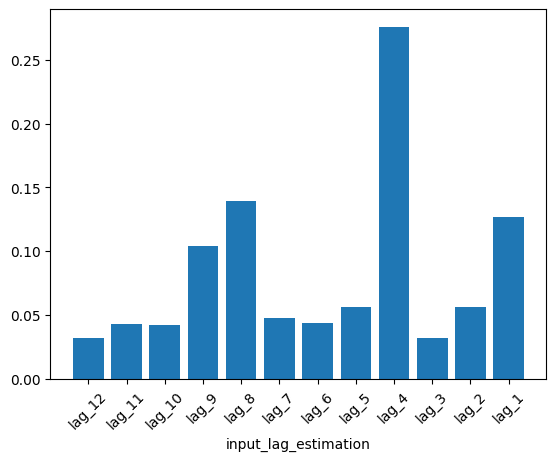

In [ ]:
# Applying RandomForestRegressor to estimate lag
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=1)
model.fit(X, y)
print(model.feature_importances_)
names = df_gen.columns.values[0:-1]  # get lag names
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names,rotation=45)
plt.xlabel('input_lag_estimation')
plt.show()

In [ ]:
window=4

From the random forest technique,
the maximum lag correlation is observed at lag 2(lag_1=lag 12) for the series.

# OPTUNA

Selecting the Best hypertuning for our prposed model

In [ ]:
def objective(trial):
  try:
    batch_size=trial.suggest_int('batch_size', 2, 8)
    LSTM_units=trial.suggest_int('LSTM_units', 40, 70)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    epochs=trial.suggest_int('epochs', 25, 50)

    scaler = MinMaxScaler()
    train_scaled_res_sq= scaler.fit_transform((residualsa**2).values.reshape(-1, 1))

    generator = TimeseriesGenerator(train_scaled_res_sq, train_scaled_res_sq,
                                    length=window, batch_size=batch_size,shuffle=False)

    model = Sequential()
    model.add(LSTM(LSTM_units,activation='relu',input_shape=(window, 1)))  # time steps, 1 feature
    model.add(Dense(1))
    optimizer =RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse',metrics=['mse'])

    model.fit(generator, epochs=epochs,verbose=0)

    last_input_seq = train_scaled_res_sq[-window:]
  # Reshape to match LSTM input shape (samples=1, time_steps, features=1)
    last_input_seq = last_input_seq.reshape((1,window, 1))


    n_future = len(test[i])
    input_seq = last_input_seq.copy()
    predictions = []

    for _ in range(n_future):
        next_pred = model.predict(input_seq, verbose=0)  # shape = (1, 1)

        predictions.append(next_pred[0, 0])  # extract scalar prediction

        # Reshape prediction to (1, 1, 1)
        reshaped_pred = next_pred.reshape(1, 1, 1)

        # Slide window: drop first step, add new prediction
        input_seq = np.append(input_seq[:, 1:, :], reshaped_pred, axis=1)

    # Inverse transform predictions to get real values
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    forecasta1 = np.array(forecasta).reshape(-1)
    predictions = np.array(predictions).reshape(-1)

    # Combine ARIMA and LSTM
    y_lstm_arima = forecasta1 - np.sqrt(predictions)

    # Ensure both arrays are 1D
    y_true = test[i].values.reshape(-1)
    y_pred = y_lstm_arima.reshape(-1)

    # Compute MSE
    mse = mean_squared_error(y_true, y_pred)

    # Take square root to get RMSE
    rmse = np.sqrt(mse)

    return rmse

  except Exception as e:
        print(f"Trial {trial.number} failed due to: {e}")
        return float('inf')  # Mark trial as very bad, but don’t stop Optuna


In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40,show_progress_bar=True)

[I 2025-08-19 20:56:28,805] A new study created in memory with name: no-name-25b9f97b-dd5a-4e12-9c23-0a5007a3565c


  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 0 failed due to: Input contains NaN.
[I 2025-08-19 20:57:06,450] Trial 0 finished with value: inf and parameters: {'batch_size': 2, 'LSTM_units': 54, 'learning_rate': 0.01957406418346706, 'epochs': 31}. Best is trial 0 with value: inf.
[I 2025-08-19 20:57:18,714] Trial 1 finished with value: 9.648588843716508 and parameters: {'batch_size': 8, 'LSTM_units': 61, 'learning_rate': 0.07410123126141942, 'epochs': 25}. Best is trial 1 with value: 9.648588843716508.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:57:43,318] Trial 2 finished with value: 7.705694151684018 and parameters: {'batch_size': 5, 'LSTM_units': 57, 'learning_rate': 0.08652790554874774, 'epochs': 42}. Best is trial 2 with value: 7.705694151684018.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:58:15,088] Trial 3 finished with value: 5.9240033357600215 and parameters: {'batch_size': 4, 'LSTM_units': 67, 'learning_rate': 0.0004474905294217908, 'epochs': 48}. Best is trial 3 with value: 5.9240033357600215.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:58:49,657] Trial 4 finished with value: 5.371810978239022 and parameters: {'batch_size': 3, 'LSTM_units': 53, 'learning_rate': 1.645037365702385e-05, 'epochs': 43}. Best is trial 4 with value: 5.371810978239022.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 20:59:10,170] Trial 5 finished with value: 5.36535114852442 and parameters: {'batch_size': 7, 'LSTM_units': 66, 'learning_rate': 5.212112349372137e-05, 'epochs': 50}. Best is trial 5 with value: 5.36535114852442.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 6 failed due to: Input contains NaN.
[I 2025-08-19 20:59:33,605] Trial 6 finished with value: inf and parameters: {'batch_size': 6, 'LSTM_units': 70, 'learning_rate': 0.005144620127351967, 'epochs': 44}. Best is trial 5 with value: 5.36535114852442.
[I 2025-08-19 21:00:07,000] Trial 7 finished with value: 5.470069494122739 and parameters: {'batch_size': 3, 'LSTM_units': 69, 'learning_rate': 0.003398842856988398, 'epochs': 42}. Best is trial 5 with value: 5.36535114852442.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 8 failed due to: Input contains NaN.
[I 2025-08-19 21:00:29,915] Trial 8 finished with value: inf and parameters: {'batch_size': 4, 'LSTM_units': 47, 'learning_rate': 0.0031560831801587777, 'epochs': 30}. Best is trial 5 with value: 5.36535114852442.
[I 2025-08-19 21:01:10,617] Trial 9 finished with value: 5.299797963532696 and parameters: {'batch_size': 2, 'LSTM_units': 54, 'learning_rate': 3.357080856587634e-05, 'epochs': 34}. Best is trial 9 with value: 5.299797963532696.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:01:47,254] Trial 10 finished with value: 4.969961766728251 and parameters: {'batch_size': 2, 'LSTM_units': 41, 'learning_rate': 0.00019457818042442743, 'epochs': 35}. Best is trial 10 with value: 4.969961766728251.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:02:26,428] Trial 11 finished with value: 5.527546140433507 and parameters: {'batch_size': 2, 'LSTM_units': 41, 'learning_rate': 0.00019935751084779679, 'epochs': 36}. Best is trial 10 with value: 4.969961766728251.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:03:05,515] Trial 12 finished with value: 5.570904510821913 and parameters: {'batch_size': 2, 'LSTM_units': 40, 'learning_rate': 8.417772891038981e-05, 'epochs': 35}. Best is trial 10 with value: 4.969961766728251.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:03:31,491] Trial 13 finished with value: 5.408035792208912 and parameters: {'batch_size': 3, 'LSTM_units': 48, 'learning_rate': 1.225698087020301e-05, 'epochs': 32}. Best is trial 10 with value: 4.969961766728251.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:03:58,564] Trial 14 finished with value: 5.296221741396495 and parameters: {'batch_size': 4, 'LSTM_units': 46, 'learning_rate': 5.948757548153205e-05, 'epochs': 39}. Best is trial 10 with value: 4.969961766728251.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:04:26,852] Trial 15 finished with value: 4.001474343598131 and parameters: {'batch_size': 5, 'LSTM_units': 46, 'learning_rate': 0.00082370663297366, 'epochs': 39}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:04:48,762] Trial 16 finished with value: 5.877464120527803 and parameters: {'batch_size': 6, 'LSTM_units': 44, 'learning_rate': 0.0013424424170494383, 'epochs': 39}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:05:07,401] Trial 17 finished with value: 5.696099619048189 and parameters: {'batch_size': 5, 'LSTM_units': 50, 'learning_rate': 0.0003668890326344792, 'epochs': 28}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:05:24,751] Trial 18 finished with value: 5.088059883661714 and parameters: {'batch_size': 8, 'LSTM_units': 43, 'learning_rate': 0.000747157315450574, 'epochs': 37}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:05:45,492] Trial 19 finished with value: 4.8755380414468625 and parameters: {'batch_size': 6, 'LSTM_units': 50, 'learning_rate': 0.00017637735412176581, 'epochs': 39}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:06:09,226] Trial 20 finished with value: 5.271216591632551 and parameters: {'batch_size': 6, 'LSTM_units': 59, 'learning_rate': 0.0016189371292444424, 'epochs': 45}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:06:27,552] Trial 21 finished with value: 5.447270296378081 and parameters: {'batch_size': 7, 'LSTM_units': 50, 'learning_rate': 0.00019051455313497229, 'epochs': 40}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:06:44,285] Trial 22 finished with value: 5.661363759269662 and parameters: {'batch_size': 7, 'LSTM_units': 44, 'learning_rate': 0.00023120470005845377, 'epochs': 34}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:07:08,357] Trial 23 finished with value: 5.092328744645111 and parameters: {'batch_size': 5, 'LSTM_units': 50, 'learning_rate': 0.0005755638455016876, 'epochs': 38}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:07:29,555] Trial 24 finished with value: 5.177926303738311 and parameters: {'batch_size': 6, 'LSTM_units': 42, 'learning_rate': 0.00012983912500531646, 'epochs': 41}. Best is trial 15 with value: 4.001474343598131.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:07:55,606] Trial 25 finished with value: 3.977369535050339 and parameters: {'batch_size': 4, 'LSTM_units': 46, 'learning_rate': 0.009675982112346528, 'epochs': 37}. Best is trial 25 with value: 3.977369535050339.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:08:22,946] Trial 26 finished with value: 4.850620011475068 and parameters: {'batch_size': 5, 'LSTM_units': 52, 'learning_rate': 0.008197365343690482, 'epochs': 46}. Best is trial 25 with value: 3.977369535050339.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 27 failed due to: Input contains NaN.
[I 2025-08-19 21:08:49,401] Trial 27 finished with value: inf and parameters: {'batch_size': 5, 'LSTM_units': 46, 'learning_rate': 0.01215539882262193, 'epochs': 46}. Best is trial 25 with value: 3.977369535050339.


/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Trial 28 failed due to: Input contains NaN.
[I 2025-08-19 21:09:20,837] Trial 28 finished with value: inf and parameters: {'batch_size': 4, 'LSTM_units': 48, 'learning_rate': 0.02385064209285145, 'epochs': 46}. Best is trial 25 with value: 3.977369535050339.


/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Trial 29 failed due to: Input contains NaN.
[I 2025-08-19 21:09:53,865] Trial 29 finished with value: inf and parameters: {'batch_size': 4, 'LSTM_units': 52, 'learning_rate': 0.01178620727759753, 'epochs': 49}. Best is trial 25 with value: 3.977369535050339.
[I 2025-08-19 21:10:13,116] Trial 30 finished with value: 4.2722026912098325 and parameters: {'batch_size': 5, 'LSTM_units': 57, 'learning_rate': 0.03579723254845737, 'epochs': 31}. Best is trial 25 with value: 3.977369535050339.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 31 failed due to: Input contains NaN.
[I 2025-08-19 21:10:32,290] Trial 31 finished with value: inf and parameters: {'batch_size': 5, 'LSTM_units': 56, 'learning_rate': 0.039874174064566156, 'epochs': 32}. Best is trial 25 with value: 3.977369535050339.
[I 2025-08-19 21:10:53,589] Trial 32 finished with value: 3.9648360405651712 and parameters: {'batch_size': 4, 'LSTM_units': 63, 'learning_rate': 0.008153957798394116, 'epochs': 27}. Best is trial 32 with value: 3.9648360405651712.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2025-08-19 21:11:15,337] Trial 33 finished with value: 5.714994409584426 and parameters: {'batch_size': 3, 'LSTM_units': 62, 'learning_rate': 0.05357952280037844, 'epochs': 26}. Best is trial 32 with value: 3.9648360405651712.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 34 failed due to: Input contains NaN.
[I 2025-08-19 21:11:37,568] Trial 34 finished with value: inf and parameters: {'batch_size': 4, 'LSTM_units': 63, 'learning_rate': 0.023675431013983776, 'epochs': 29}. Best is trial 32 with value: 3.9648360405651712.
[I 2025-08-19 21:11:57,087] Trial 35 finished with value: 5.342680092943503 and parameters: {'batch_size': 4, 'LSTM_units': 59, 'learning_rate': 0.002532754851463345, 'epochs': 27}. Best is trial 32 with value: 3.9648360405651712.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 36 failed due to: Input contains NaN.
[I 2025-08-19 21:12:15,135] Trial 36 finished with value: inf and parameters: {'batch_size': 5, 'LSTM_units': 65, 'learning_rate': 0.006298673719830327, 'epochs': 25}. Best is trial 32 with value: 3.9648360405651712.
[I 2025-08-19 21:12:39,496] Trial 37 finished with value: 4.566543407973227 and parameters: {'batch_size': 3, 'LSTM_units': 59, 'learning_rate': 0.0451425754086349, 'epochs': 32}. Best is trial 32 with value: 3.9648360405651712.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Trial 38 failed due to: Input contains NaN.
[I 2025-08-19 21:13:02,031] Trial 38 finished with value: inf and parameters: {'batch_size': 4, 'LSTM_units': 64, 'learning_rate': 0.09981277124955353, 'epochs': 30}. Best is trial 32 with value: 3.9648360405651712.


/tmp/ipython-input-2604489829.py:49: RuntimeWarning: invalid value encountered in sqrt
  y_lstm_arima = forecasta1 - np.sqrt(predictions)


Trial 39 failed due to: Input contains NaN.
[I 2025-08-19 21:13:20,143] Trial 39 finished with value: inf and parameters: {'batch_size': 5, 'LSTM_units': 56, 'learning_rate': 0.012651397479148585, 'epochs': 28}. Best is trial 32 with value: 3.9648360405651712.


In [ ]:
best_trial = study.best_trial
print("Best trial number:", best_trial.number)
print("Best value (objective):", best_trial.value)
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")


Best trial number: 32
Best value (objective): 3.9648360405651712
Best hyperparameters:
  batch_size: 4
  LSTM_units: 63
  learning_rate: 0.008153957798394116
  epochs: 27
